In [1]:
## prepare packages
#%pip install -U pandas
#%pip install -U matplotlib
#%pip install -U gensim
#%pip install -U scipy
#%pip install -U pyLDAvis
#%pip install -U plotly
#%pip install -U 'nbformat>=4.2.0'

In [2]:
## import modules
import os, sys
## maake accessible files on level immediately above 
sys.path.append(os.path.join(os.path.dirname("__file__"), ".."))
## import other modules
import re
import gzip, glob
import unicodedata

In [3]:
## Settings
verbose              = True
save_results         = False
targets_csv          = True
## source sampling
source_sampling      = True
source_sampling_rate = 0.03 # optimal values depend on kinds of source
## doc # The longer sentences become, the less precise pairing becomes
min_doc_size         = 4 # larger value avoids Sum not equals 1 error
max_doc_size         = 9
add_boundaries       = True
boundary_symbol      = '#'
lower_chars          = True
strip_accents        = True
## term settings
ngram_is_inclusive    = True # takes significantly more time to complete but invites sum error if False with larger n, 
ngram_is_minimally_inclusive = True
max_gap_val           = round(max_doc_size * 0.5) # This needs to be smaller than other cases.
## Skippy n-gram の隙間を表わす記号
gap_marker            = "…"
## spell term と sound term の連結記号
pair_marker           = " :: "
## set spell term_type
sp_term_types  = [ 'sp_1gram',
                  'sp_2gram', 'sp_3gram', 'sp_4gram', 'sp_5ram',
                 'sp_skippy2gram', 'sp_skippy3gram', 'sp_skippy4gram' ]
sp_term_type   = sp_term_types[3]
## set sound term_type
sn_term_types = [ 'sn_1gram',
                 'sn_2gram', 'sn_3gram', 'sn_4gram', 'sn_5ram',
                 'sn_skippy2gram', 'sn_skippy3gram', 'sn_skippy4gram' ]
sn_term_type = sn_term_types[3]
print(f"sp_term_type: {sp_term_type}")
print(f"sn_term_type: {sn_term_type}")

sp_term_type: sp_4gram
sn_term_type: sn_4gram


In [4]:
## DTM term filtering
## This often causes Not all rows (distributions) in doc_topic_dists sum to 1 at pyLDAvis.
apply_term_freq_filtering  = False
term_minfreq         = 1 # Seems like even 2 is too large for a single language
apply_term_abuse_filtering = False
term_abuse_threshold = 0.1 # 0.006 looks like the smallest effective value
#
if add_boundaries:
    min_bot_size = min_doc_size
else:
    min_bot_size = min_doc_size

In [5]:
## HDP
use_HDP       = True
max_n_topics  = 90
## LDA
n_topics      = 60 # 精度にはあまり影響しない？
if use_HDP:
    n_topics  = max_n_topics
    ldx_name  = "HDP"
else:
    ldx_name  = "LDA"
## tSNE
top_perplexity_reduct_rate = 0.33

In [8]:
## get data
import glob
data_dir1 = "data/open-dict-ipa/data1"
data_dir2 = "data/open-dict-ipa/data1a"
files = []
for dir in [ data_dir1, data_dir2 ]:
    gz_files = glob.glob(f"{dir}/*.gz")
    files.extend(gz_files)
    csv_files = glob.glob(f"{dir}/*.csv")
    files.extend(csv_files)
    txt_files = glob.glob(f"{data_dir2}/*.txt")
    files.extend(txt_files)
#
files

['data/open-dict-ipa/data1/yue.csv.gz',
 'data/open-dict-ipa/data1/vi_S.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/zh_hant.csv.gz',
 'data/open-dict-ipa/data1/sw.csv.gz',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/vi_C.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 'data/open-dict-ipa/data1/sv.csv.gz',
 'data/open-dict-ipa/data1/or.csv.gz',
 'data/open-dict-ipa/data1/zh_hans.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/vi_N.csv.gz',
 'data/open-dict-ipa/data1/j

In [9]:
## select language and file
lang_names = {  'en' : 'English',
                'de' : 'German',
                'fr' : 'French'
            }
#
lang_keys = [ 'en', 'de', 'fr' ]
lang_key = lang_keys[0]
lang_name = lang_names[lang_key]
print(f"lang_name: {lang_name} [lang_key: {lang_key}]")
#
files = [ file for file in files if f"/{lang_key}" in file ]
print(files)
#
target_attr = "US"
if len(target_attr) > 0:
    print(f"target_attr: {target_attr}")
    selected_files = [ file for file in files if target_attr in file ]
else:
    selected_files = files
selected_files

lang_name: English [lang_key: en]
['data/open-dict-ipa/data1/en_US.csv.gz', 'data/open-dict-ipa/data1/en_UK.csv.gz']
target_attr: US


['data/open-dict-ipa/data1/en_US.csv.gz']

In [11]:
## build data from files
import re, unicodedata
import pandas as pd
check = False
dfx = [ ]
var_names = [ 'did', 'sid', 'sp_word', 'sn_word',
            'sp_word_size', 'sn_word_size', 'paired_terms', 
            'sp_1gram', 'sp_2gram', 'sp_3gram',
            'sp_skippy2gram', 'sp_skippy3gram',
            'sn_1gram', 'sn_2gram', 'sn_3gram', 
            'sn_skippy2gram', 'sn_skippy3gram' ]

#
col_names = [ 'sp_word', 'sn_word' ]
for j, target_file in enumerate(selected_files):
    if target_file.endswith(".gz"):
        with gzip.open(target_file, "rt") as f:
            raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
    else:
        with open(target_file, "rt") as f:
            raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
#
raw_df

,sp_word,sn_word
0,'bout,/ˈbaʊt/
1,'cause,/kəz/
2,'course,/ˈkɔɹs/
3,'cuse,/ˈkjuz/
4,'em,/əm/
...,...,...
125922,zysk,/ˈzaɪsk/
125923,zyskowski,/zɪˈskɔfski/
125924,zyuganov,"/ˈzjuɡɑnɑv/, /ˈzuɡɑnɑv/"
125925,zyuganov's,"/ˈzjuɡɑnɑvz/, /ˈzuɡɑnɑvz/"


In [14]:
## modify spell
raw_df['sp_word'] = raw_df['sp_word'].apply(lambda x: unicodedata.normalize('NFC', str(x)))
if lower_chars:
    raw_df['sp_word'] = raw_df['sp_word'].apply(lambda x: x.lower())

## modify sound symbols
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: unicodedata.normalize('NFC', str(x)))
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r"/", "", x))
if strip_accents:
    raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r'"', "", x))
    raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r"[ˈˌ]", "", x))
#
raw_df

,sp_word,sn_word
0,'bout,baʊt
1,'cause,kəz
2,'course,kɔɹs
3,'cuse,kjuz
4,'em,əm
...,...,...
125922,zysk,zaɪsk
125923,zyskowski,zɪskɔfski
125924,zyuganov,"zjuɡɑnɑv, zuɡɑnɑv"
125925,zyuganov's,"zjuɡɑnɑvz, zuɡɑnɑvz"


In [ ]:


dids = [ ]
sids = [ ]
Spells = [ ]
Sounds = [ ]
#
if len(spell) > 0 and len(sound) > 0:
    dids.append(j + 1)
    sids.append(i + 1)
    Spells.append(spell)
    Sounds.append(sound)
#
df['did'] = dids
df['sid'] = sids
df['sp_word'] = Spells
df['sn_word'] = Sounds
if check:
    print(df)
dfx.append(df)
## integrate dfs
df = pd.concat(dfx)
df[var_names[:4]]

In [2008]:
## Source sampling
if source_sampling:
    original_size = len(df)
    df = df.sample(round(len(df) * source_sampling_rate))
    print(f"sampled {len(df)} ({source_sampling_rate:0.3f}) rows by discarding {original_size - len(df)} rows")

sampled 3778 (0.030) rows by discarding 122149 rows


In [2009]:
## Tokenization
import gzip, re
import pandas as pd
check = False
Snx = [ ]
Spx = [ ]
for i, row in df.iterrows():
    Spt = row['sp_word']
    Snt = row['sn_word']
    split_pattern = r""
    ## Spell
    sp_seg = [ x for x in re.split(split_pattern, Spt) if len(x) > 0 ]
    if check:
        print(sp_seg)
    Spx.append(sp_seg)
    ## Sound
    sn_seg = [ x for x in re.split(split_pattern, Snt) if len(x) > 0 ]
    if check:
        print(sn_seg)
    Snx.append(sn_seg)
## Spell
try:
    df['sp_1gram'] = Spx
except ValueError:
    pass
## Sound
try:
    df['sn_1gram'] = Snx
except ValueError:
    pass
## check result
if verbose:
    df

In [2010]:
## add sp_word_size column
df['sp_word_size'] = df['sp_1gram'].apply(lambda x: len(x))
if verbose:
    df

In [2011]:
## add sn_word_size column
df['sn_word_size'] = df['sn_1gram'].apply(lambda x: len(x))
if verbose:
    df

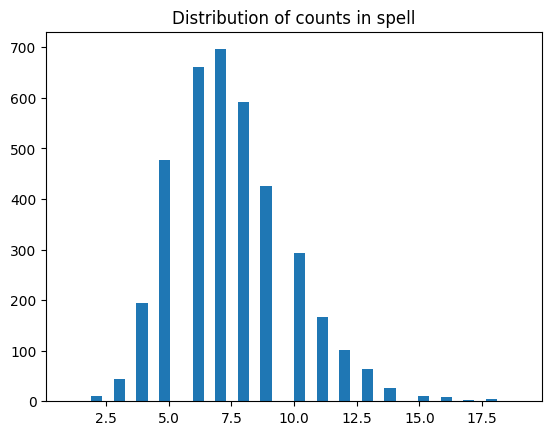

In [2012]:
## 語の綴り文字数の分布
import matplotlib.pyplot as plt
plt.hist(df['sp_word_size'], bins = 40)
plt.title(f"Distribution of counts in spell")
plt.show()

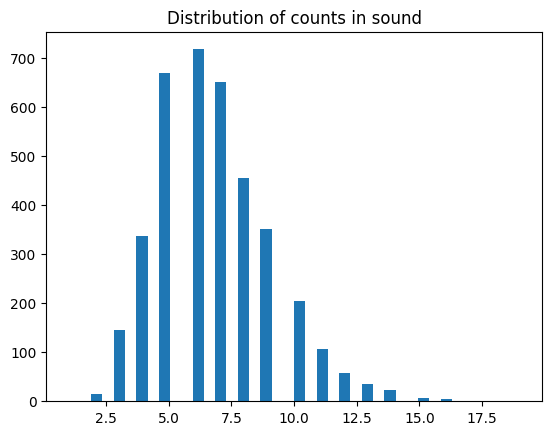

In [2013]:
## 語の発音記号数の分布
import matplotlib.pyplot as plt
plt.hist(df['sn_word_size'], bins = 40)
plt.title(f"Distribution of counts in sound")
plt.show()

In [2014]:
## 長さで濾過
original_size = len(df)
measures = ['sp_word_size', 'sn_word_size']
measure = measures[1]
print(f"discarding pairs whose {measure} part has less than {min_doc_size} chars")
df = df[df[measure] >= min_doc_size]

print(f"discarding pairs whose {measure} part has more than {max_doc_size} chars")
df = df[df[measure] < max_doc_size]

current_size = len(df)
size_diff = original_size - current_size
print(f"{size_diff} ({size_diff/original_size:.3f}) pairs were removed")
print(f"{current_size} pairs remain")

discarding pairs whose sn_word_size part has less than 5 chars
discarding pairs whose sn_word_size part has more than 11 chars
733 (0.194) pairs were removed
3045 pairs remain


In [2015]:
## add boundaries
df['sp_word'] = df['sp_word'].apply(lambda x: f"{boundary_symbol}{x}{boundary_symbol}")
df['sn_word'] = df['sn_word'].apply(lambda x: f"{boundary_symbol}{x}{boundary_symbol}")
df[['sp_word', 'sn_word']]

,sp_word,sn_word
93880,#renfred#,#ɹɛnfɝd#
3117,#amado#,#ɑmɑdoʊ#
47264,#guard's#,#ɡɑɹdz#
43235,#garver's#,#ɡɑɹvɝz#
92087,#razzano#,#ɹɑtsɑnoʊ#
...,...,...
112356,#tempting#,#tɛmptɪŋ#
118111,#utica#,#jutəkə#
38439,#fearless#,#fɪɹɫəs#
12984,#bostock#,#boʊstɑk#


In [2016]:
## Install nltk if necessary
#!pip install -U nltk

n-grams の構築

In [2017]:
def gen_ngrams_from_str(t: str, n: int, sep: str = r"", joint: str = "", check = False):
    'returns the list of character n-grams from a given string'
    import re
    segs = [ x for x in re.split(sep, t) if len(x) > 0 ]
    if check:
        print(segs)
    ## short input
    if len(segs) <= n:
        return segs
    ## long enough input
    G = [ ]
    for i in range(len(segs)):
        try:
            b = segs[ i : i + n ]
            if check:
                print(b)
            c = joint.join(b)
            if check:
                print(c)
            if len(c) == n:
                G.append(c)
        except IndexError:
            pass
    return G

In [2018]:
## spell 2-gram
import ngrams
n_for_ngram = 2
sp_2grams = [ gen_ngrams_from_str(w, n = n_for_ngram, check = False) for w in df['sp_word'] ]
## make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sp_2grams):
        gram.extend(list(df['sp_1gram'])[i])
## populate values on sn_skippy2gram
#df.loc[:,'sn_skippy2gram'] = sn_skippy2grams
df['sp_2gram'] = sp_2grams

In [2019]:
## spell 3-gram
import ngrams
n_for_ngram = 3
sp_3grams = [ gen_ngrams_from_str(w, n = n_for_ngram, check = False) for w in df['sp_word'] ]
## make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sp_3grams):
        supplement = list(df['sp_2gram'])[i]
        if ngram_is_minimally_inclusive:
            supplement = [ g for g in supplement if len(g) >= (n_for_ngram - 1) ]
        gram.extend(supplement)
## populate values on sn_skippy2gram
df['sp_3gram'] = sp_3grams
df['sp_3gram']

93880     [#re, ren, enf, nfr, fre, red, ed#, #r, re, en...
3117      [#am, ama, mad, ado, do#, #a, am, ma, ad, do, o#]
47264     [#gu, gua, uar, ard, rd', d's, 's#, #g, gu, ua...
43235     [#ga, gar, arv, rve, ver, er', r's, 's#, #g, g...
92087     [#ra, raz, azz, zza, zan, ano, no#, #r, ra, az...
                                ...                        
112356    [#te, tem, emp, mpt, pti, tin, ing, ng#, #t, t...
118111    [#ut, uti, tic, ica, ca#, #u, ut, ti, ic, ca, a#]
38439     [#fe, fea, ear, arl, rle, les, ess, ss#, #f, f...
12984     [#bo, bos, ost, sto, toc, ock, ck#, #b, bo, os...
32845     [#du, dug, ugu, gua, uay, ay#, #d, du, ug, gu,...
Name: sp_3gram, Length: 3045, dtype: object

In [2020]:
## spell 4-gram
import ngrams
n_for_ngram = 4
sp_4grams = [ gen_ngrams_from_str(w, n = n_for_ngram, check = False) for w in df['sp_word'] ]
## Make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sp_4grams):
        supplement = list(df['sp_3gram'])[i]
        if ngram_is_minimally_inclusive:
            supplement = [ g for g in supplement if len(g) >= (n_for_ngram - 1) ]
        gram.extend(supplement)
## Populate values on sn_4gram
df['sp_4gram'] = sp_4grams
df['sp_4gram']

93880     [#ren, renf, enfr, nfre, fred, red#, #re, ren,...
3117      [#ama, amad, mado, ado#, #am, ama, mad, ado, do#]
47264     [#gua, guar, uard, ard', rd's, d's#, #gu, gua,...
43235     [#gar, garv, arve, rver, ver', er's, r's#, #ga...
92087     [#raz, razz, azza, zzan, zano, ano#, #ra, raz,...
                                ...                        
112356    [#tem, temp, empt, mpti, ptin, ting, ing#, #te...
118111    [#uti, utic, tica, ica#, #ut, uti, tic, ica, ca#]
38439     [#fea, fear, earl, arle, rles, less, ess#, #fe...
12984     [#bos, bost, osto, stoc, tock, ock#, #bo, bos,...
32845     [#dug, dugu, ugua, guay, uay#, #du, dug, ugu, ...
Name: sp_4gram, Length: 3045, dtype: object

In [2021]:
## spell 5-gram
import ngrams
n_for_ngram = 5
sp_5grams = [ gen_ngrams_from_str(w, n = n_for_ngram, check = False) for w in df['sp_word'] ]
## Make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sp_5grams):
        supplement = list(df['sp_4gram'])[i]
        if ngram_is_minimally_inclusive:
            supplement = [ g for g in supplement if len(g) >= (n_for_ngram - 1) ]
        gram.extend(supplement)
## update df
df['sp_5gram'] = sp_5grams
df['sp_5gram']

93880     [#renf, renfr, enfre, nfred, fred#, #ren, renf...
3117          [#amad, amado, mado#, #ama, amad, mado, ado#]
47264     [#guar, guard, uard', ard's, rd's#, #gua, guar...
43235     [#garv, garve, arver, rver', ver's, er's#, #ga...
92087     [#razz, razza, azzan, zzano, zano#, #raz, razz...
                                ...                        
112356    [#temp, tempt, empti, mptin, pting, ting#, #te...
118111        [#utic, utica, tica#, #uti, utic, tica, ica#]
38439     [#fear, fearl, earle, arles, rless, less#, #fe...
12984     [#bost, bosto, ostoc, stock, tock#, #bos, bost...
32845     [#dugu, dugua, uguay, guay#, #dug, dugu, ugua,...
Name: sp_5gram, Length: 3045, dtype: object

In [2022]:
## spell skippy 2-gram
import ngrams_skippy
n_for_ngram = 2
sp_skippy2grams = [ ngrams_skippy.gen_skippy_2grams(x, sep = "",
                                                        max_distance = max_gap_val,
                                                        missing_mark = gap_marker) for x in df['sp_1gram'] ]
## make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sp_skippy2grams):
        gram.extend(list(df['sp_1gram'])[i])
## populate values on sn_skippy2gram
#df.loc[:,'sn_skippy2gram'] = sn_skippy2grams
df['sp_skippy2gram'] = sp_skippy2grams
df['sp_skippy2gram']

93880     [re, r…n, r…f, r…r, r…e, r…d, en, e…f, e…r, e…...
3117      [am, a…a, a…d, a…o, ma, m…d, m…o, ad, do, a, m...
47264     [gu, g…a, g…r, g…d, g…', g…s, ua, u…r, u…d, u…...
43235     [ga, g…r, g…v, g…e, g…', ar, a…v, a…e, a…r, a…...
92087     [ra, r…z, r…a, r…n, r…o, az, a…z, a…a, a…n, a…...
                                ...                        
112356    [te, t…m, t…p, t…t, t…i, t…n, em, e…p, e…t, e…...
118111    [ut, u…i, u…c, u…a, ti, t…c, t…a, ic, i…a, ca,...
38439     [fe, f…a, f…r, f…l, f…e, f…s, ea, e…r, e…l, e…...
12984     [bo, b…s, b…t, b…o, b…c, b…k, os, o…t, o…o, o…...
32845     [du, d…g, d…u, d…a, d…y, ug, u…u, u…a, u…y, gu...
Name: sp_skippy2gram, Length: 3045, dtype: object

In [2023]:
## spell skippy 3-gram
import ngrams_skippy
n_for_ngram = 3
sp_skippy3grams = [ ngrams_skippy.gen_skippy_3grams(x, sep = "",
                                                        max_distance = max_gap_val,
                                                        missing_mark = gap_marker) for x in df['sp_1gram'] ]

## Make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sp_skippy3grams):
        supplement = list(df['sp_skippy2gram'])[i]
        if ngram_is_minimally_inclusive:
            supplement = [ g for g in supplement if len(g) >= (n_for_ngram - 1) ]
        gram.extend(supplement)
## update
df['sp_skippy3gram'] = sp_skippy3grams
df['sp_skippy3gram']

93880     [ren, re…f, re…r, re…e, re…d, r…nf, r…n…r, r…n...
3117      [ama, am…d, am…o, a…ad, a…a…o, a…do, mad, ma…o...
47264     [gua, gu…r, gu…d, gu…', gu…s, g…ar, g…a…d, g…a...
43235     [gar, ga…v, ga…e, ga…r, ga…', g…rv, g…r…e, g…r...
92087     [raz, ra…z, ra…a, ra…n, ra…o, r…zz, r…z…a, r…z...
                                ...                        
112356    [tem, te…p, te…t, te…i, te…n, t…mp, t…m…t, t…m...
118111    [uti, ut…c, ut…a, u…ic, u…i…a, u…ca, tic, ti…a...
38439     [fea, fe…r, fe…l, fe…e, fe…s, f…ar, f…a…l, f…a...
12984     [bos, bo…t, bo…o, bo…c, bo…k, b…st, b…s…o, b…s...
32845     [dug, du…u, du…a, du…y, d…gu, d…g…a, d…g…y, d…...
Name: sp_skippy3gram, Length: 3045, dtype: object

In [2024]:
## spell skippy 4-gram
import ngrams_skippy
n_for_ngram = 4
sp_skippy4grams = [ ngrams_skippy.gen_skippy_4grams(x, sep = "",
                                                        max_distance = max_gap_val,
                                                        missing_mark = gap_marker) for x in df['sp_1gram'] ]

## Make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sp_skippy4grams):
        supplement = list(df['sp_skippy3gram'])[i]
        if ngram_is_minimally_inclusive:
            supplement = [ g for g in supplement if len(g) >= (n_for_ngram - 1) ]
        gram.extend(supplement)
## Populate values on sn_skippy2gram
df['sp_skippy4gram'] = sp_skippy4grams
df['sp_skippy4gram']

93880     [renf, ren…r, ren…e, ren…d, re…fr, re…f…e, re…...
3117      [amad, ama…o, am…do, a…a…do, mado, ama, am…d, ...
47264     [guar, gua…d, gua…', gua…s, gu…rd, gu…r…', gu…...
43235     [garv, gar…e, gar…r, gar…', ga…ve, ga…v…r, ga…...
92087     [razz, raz…a, raz…n, raz…o, ra…za, ra…z…n, ra…...
                                ...                        
112356    [temp, tem…t, tem…i, tem…n, te…pt, te…p…i, te…...
118111    [utic, uti…a, ut…ca, u…i…ca, tica, uti, ut…c, ...
38439     [fear, fea…l, fea…e, fea…s, fe…rl, fe…r…e, fe…...
12984     [bost, bos…o, bos…c, bos…k, bo…to, bo…t…c, bo…...
32845     [dugu, dug…a, dug…y, du…ua, du…u…y, du…ay, d…g...
Name: sp_skippy4gram, Length: 3045, dtype: object

In [2025]:
## check result
df[ [ 'sp_word', 'sp_skippy2gram', 'sp_skippy3gram', 'sp_skippy4gram' ] ]

,sp_word,sp_skippy2gram,sp_skippy3gram,sp_skippy4gram
93880,#renfred#,"[re, r…n, r…f, r…r, r…e, r…d, en, e…f, e…r, e…...","[ren, re…f, re…r, re…e, re…d, r…nf, r…n…r, r…n...","[renf, ren…r, ren…e, ren…d, re…fr, re…f…e, re…..."
3117,#amado#,"[am, a…a, a…d, a…o, ma, m…d, m…o, ad, do, a, m...","[ama, am…d, am…o, a…ad, a…a…o, a…do, mad, ma…o...","[amad, ama…o, am…do, a…a…do, mado, ama, am…d, ..."
47264,#guard's#,"[gu, g…a, g…r, g…d, g…', g…s, ua, u…r, u…d, u…...","[gua, gu…r, gu…d, gu…', gu…s, g…ar, g…a…d, g…a...","[guar, gua…d, gua…', gua…s, gu…rd, gu…r…', gu…..."
43235,#garver's#,"[ga, g…r, g…v, g…e, g…', ar, a…v, a…e, a…r, a…...","[gar, ga…v, ga…e, ga…r, ga…', g…rv, g…r…e, g…r...","[garv, gar…e, gar…r, gar…', ga…ve, ga…v…r, ga…..."
92087,#razzano#,"[ra, r…z, r…a, r…n, r…o, az, a…z, a…a, a…n, a…...","[raz, ra…z, ra…a, ra…n, ra…o, r…zz, r…z…a, r…z...","[razz, raz…a, raz…n, raz…o, ra…za, ra…z…n, ra…..."
...,...,...,...,...
112356,#tempting#,"[te, t…m, t…p, t…t, t…i, t…n, em, e…p, e…t, e…...","[tem, te…p, te…t, te…i, te…n, t…mp, t…m…t, t…m...","[temp, tem…t, tem…i, tem…n, te…pt, te…p…i, te…..."
118111,#utica#,"[ut, u…i, u…c, u…a, ti, t…c, t…a, ic, i…a, ca,...","[uti, ut…c, ut…a, u…ic, u…i…a, u…ca, tic, ti…a...","[utic, uti…a, ut…ca, u…i…ca, tica, uti, ut…c, ..."
38439,#fearless#,"[fe, f…a, f…r, f…l, f…e, f…s, ea, e…r, e…l, e…...","[fea, fe…r, fe…l, fe…e, fe…s, f…ar, f…a…l, f…a...","[fear, fea…l, fea…e, fea…s, fe…rl, fe…r…e, fe…..."
12984,#bostock#,"[bo, b…s, b…t, b…o, b…c, b…k, os, o…t, o…o, o…...","[bos, bo…t, bo…o, bo…c, bo…k, b…st, b…s…o, b…s...","[bost, bos…o, bos…c, bos…k, bo…to, bo…t…c, bo…..."


In [2026]:
## inspect frequent tokens
from collections import Counter
sn_chars_all = [ ] 
[ sn_chars_all.extend(list(x)) for x in df['sn_1gram'] ]
sn_char_freqs = Counter(sn_chars_all)
## Show most frequent 10 segments
sn_char_freqs.most_common(10)

[('ɪ', 1665),
 ('ə', 1585),
 ('n', 1360),
 ('t', 1238),
 ('s', 1169),
 ('ɫ', 1168),
 ('ɹ', 1039),
 ('k', 967),
 ('d', 931),
 ('i', 747)]

n-grams の構築

In [2027]:
## sound 2-gram
import ngrams
sn_2grams = [ gen_ngrams_from_str(w, n = 2, sep = r"", check = False) for w in df['sn_word'] ]
## Make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sn_2grams):
        gram.extend(list(df['sn_1gram'])[i])
## update df     
df['sn_2gram'] = sn_2grams
df['sn_2gram']

93880        [#ɹ, ɹɛ, ɛn, nf, fɝ, ɝd, d#, ɹ, ɛ, n, f, ɝ, d]
3117         [#ɑ, ɑm, mɑ, ɑd, do, oʊ, ʊ#, ɑ, m, ɑ, d, o, ʊ]
47264               [#ɡ, ɡɑ, ɑɹ, ɹd, dz, z#, ɡ, ɑ, ɹ, d, z]
43235        [#ɡ, ɡɑ, ɑɹ, ɹv, vɝ, ɝz, z#, ɡ, ɑ, ɹ, v, ɝ, z]
92087     [#ɹ, ɹɑ, ɑt, ts, sɑ, ɑn, no, oʊ, ʊ#, ɹ, ɑ, t, ...
                                ...                        
112356    [#t, tɛ, ɛm, mp, pt, tɪ, ɪŋ, ŋ#, t, ɛ, m, p, t...
118111       [#j, ju, ut, tə, ək, kə, ə#, j, u, t, ə, k, ə]
38439        [#f, fɪ, ɪɹ, ɹɫ, ɫə, əs, s#, f, ɪ, ɹ, ɫ, ə, s]
12984     [#b, bo, oʊ, ʊs, st, tɑ, ɑk, k#, b, o, ʊ, s, t...
32845               [#d, də, əɡ, ɡe, eɪ, ɪ#, d, ə, ɡ, e, ɪ]
Name: sn_2gram, Length: 3045, dtype: object

In [2028]:
## sound 3-gram
import ngrams
n_for_ngram = 3
sn_3grams = [ gen_ngrams_from_str(w, n = n_for_ngram, sep = r"", check = False) for w in df['sn_word'] ]
## Make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sn_3grams):
        supplement = list(df['sn_2gram'])[i]
        if ngram_is_minimally_inclusive:
            supplement = [ g for g in supplement if len(g) >= (n_for_ngram - 1) ]
        gram.extend(supplement)
## update df
df['sn_3gram'] = sn_3grams
df['sn_3gram']

93880     [#ɹɛ, ɹɛn, ɛnf, nfɝ, fɝd, ɝd#, #ɹ, ɹɛ, ɛn, nf,...
3117      [#ɑm, ɑmɑ, mɑd, ɑdo, doʊ, oʊ#, #ɑ, ɑm, mɑ, ɑd,...
47264     [#ɡɑ, ɡɑɹ, ɑɹd, ɹdz, dz#, #ɡ, ɡɑ, ɑɹ, ɹd, dz, z#]
43235     [#ɡɑ, ɡɑɹ, ɑɹv, ɹvɝ, vɝz, ɝz#, #ɡ, ɡɑ, ɑɹ, ɹv,...
92087     [#ɹɑ, ɹɑt, ɑts, tsɑ, sɑn, ɑno, noʊ, oʊ#, #ɹ, ɹ...
                                ...                        
112356    [#tɛ, tɛm, ɛmp, mpt, ptɪ, tɪŋ, ɪŋ#, #t, tɛ, ɛm...
118111    [#ju, jut, utə, tək, əkə, kə#, #j, ju, ut, tə,...
38439     [#fɪ, fɪɹ, ɪɹɫ, ɹɫə, ɫəs, əs#, #f, fɪ, ɪɹ, ɹɫ,...
12984     [#bo, boʊ, oʊs, ʊst, stɑ, tɑk, ɑk#, #b, bo, oʊ...
32845     [#də, dəɡ, əɡe, ɡeɪ, eɪ#, #d, də, əɡ, ɡe, eɪ, ɪ#]
Name: sn_3gram, Length: 3045, dtype: object

In [2029]:
## sound 4-gram
import ngrams
n_for_ngram = 4
sn_4grams = [ gen_ngrams_from_str(w, n = n_for_ngram, sep = r"", check = False) for w in df['sn_word'] ]
## Make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sn_4grams):
        supplement = list(df['sn_3gram'])[i]
        if ngram_is_minimally_inclusive:
            supplement = [ g for g in supplement if len(g) >= (n_for_ngram - 1) ]
        gram.extend(supplement)
## update df
df['sn_4gram'] = sn_4grams
df['sn_4gram']

93880     [#ɹɛn, ɹɛnf, ɛnfɝ, nfɝd, fɝd#, #ɹɛ, ɹɛn, ɛnf, ...
3117      [#ɑmɑ, ɑmɑd, mɑdo, ɑdoʊ, doʊ#, #ɑm, ɑmɑ, mɑd, ...
47264     [#ɡɑɹ, ɡɑɹd, ɑɹdz, ɹdz#, #ɡɑ, ɡɑɹ, ɑɹd, ɹdz, dz#]
43235     [#ɡɑɹ, ɡɑɹv, ɑɹvɝ, ɹvɝz, vɝz#, #ɡɑ, ɡɑɹ, ɑɹv, ...
92087     [#ɹɑt, ɹɑts, ɑtsɑ, tsɑn, sɑno, ɑnoʊ, noʊ#, #ɹɑ...
                                ...                        
112356    [#tɛm, tɛmp, ɛmpt, mptɪ, ptɪŋ, tɪŋ#, #tɛ, tɛm,...
118111    [#jut, jutə, utək, təkə, əkə#, #ju, jut, utə, ...
38439     [#fɪɹ, fɪɹɫ, ɪɹɫə, ɹɫəs, ɫəs#, #fɪ, fɪɹ, ɪɹɫ, ...
12984     [#boʊ, boʊs, oʊst, ʊstɑ, stɑk, tɑk#, #bo, boʊ,...
32845     [#dəɡ, dəɡe, əɡeɪ, ɡeɪ#, #də, dəɡ, əɡe, ɡeɪ, eɪ#]
Name: sn_4gram, Length: 3045, dtype: object

In [2030]:
## sound 5-gram
import ngrams
n_for_ngram = 5
sn_5grams = [ gen_ngrams_from_str(w, n = n_for_ngram, sep = r"", check = False) for w in df['sn_word'] ]
## Make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sn_5grams):
        supplement = list(df['sn_4gram'])[i]
        if ngram_is_minimally_inclusive:
            supplement = [ g for g in supplement if len(g) >= (n_for_ngram - 1) ]
        gram.extend(supplement)
## update df
df['sn_5gram'] = sn_5grams
df['sn_5gram']

93880     [#ɹɛnf, ɹɛnfɝ, ɛnfɝd, nfɝd#, #ɹɛn, ɹɛnf, ɛnfɝ,...
3117      [#ɑmɑd, ɑmɑdo, mɑdoʊ, ɑdoʊ#, #ɑmɑ, ɑmɑd, mɑdo,...
47264         [#ɡɑɹd, ɡɑɹdz, ɑɹdz#, #ɡɑɹ, ɡɑɹd, ɑɹdz, ɹdz#]
43235     [#ɡɑɹv, ɡɑɹvɝ, ɑɹvɝz, ɹvɝz#, #ɡɑɹ, ɡɑɹv, ɑɹvɝ,...
92087     [#ɹɑts, ɹɑtsɑ, ɑtsɑn, tsɑno, sɑnoʊ, ɑnoʊ#, #ɹɑ...
                                ...                        
112356    [#tɛmp, tɛmpt, ɛmptɪ, mptɪŋ, ptɪŋ#, #tɛm, tɛmp...
118111    [#jutə, jutək, utəkə, təkə#, #jut, jutə, utək,...
38439     [#fɪɹɫ, fɪɹɫə, ɪɹɫəs, ɹɫəs#, #fɪɹ, fɪɹɫ, ɪɹɫə,...
12984     [#boʊs, boʊst, oʊstɑ, ʊstɑk, stɑk#, #boʊ, boʊs...
32845         [#dəɡe, dəɡeɪ, əɡeɪ#, #dəɡ, dəɡe, əɡeɪ, ɡeɪ#]
Name: sn_5gram, Length: 3045, dtype: object

In [2031]:
## sound skippy 2-gram
import ngrams_skippy
sn_skippy2grams = [ ngrams_skippy.gen_skippy_2grams(x, sep = "",
                                                      max_distance = max_gap_val,
                                                      missing_mark = gap_marker) for x in df['sn_1gram'] ]

## Make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sn_skippy2grams):
        gram.extend(list(df['sn_1gram'])[i])
    
#df.loc[:,'sn_skippy2gram'] = sn_skippy2grams # causes error
df['sn_skippy2gram'] = sn_skippy2grams
df['sn_skippy2gram']

93880     [ɹɛ, ɹ…n, ɹ…f, ɹ…ɝ, ɹ…d, ɛn, ɛ…f, ɛ…ɝ, ɛ…d, nf...
3117      [ɑm, ɑ…ɑ, ɑ…d, ɑ…o, ɑ…ʊ, mɑ, m…d, m…o, m…ʊ, ɑd...
47264     [ɡɑ, ɡ…ɹ, ɡ…d, ɡ…z, ɑɹ, ɑ…d, ɑ…z, ɹd, ɹ…z, dz,...
43235     [ɡɑ, ɡ…ɹ, ɡ…v, ɡ…ɝ, ɡ…z, ɑɹ, ɑ…v, ɑ…ɝ, ɑ…z, ɹv...
92087     [ɹɑ, ɹ…t, ɹ…s, ɹ…ɑ, ɹ…n, ɹ…o, ɑt, ɑ…s, ɑ…ɑ, ɑ…...
                                ...                        
112356    [tɛ, t…m, t…p, t…t, t…ɪ, t…ŋ, ɛm, ɛ…p, ɛ…t, ɛ…...
118111    [ju, j…t, j…ə, j…k, ut, u…ə, u…k, tə, t…k, t…ə...
38439     [fɪ, f…ɹ, f…ɫ, f…ə, f…s, ɪɹ, ɪ…ɫ, ɪ…ə, ɪ…s, ɹɫ...
12984     [bo, b…ʊ, b…s, b…t, b…ɑ, b…k, oʊ, o…s, o…t, o…...
32845     [də, d…ɡ, d…e, d…ɪ, əɡ, ə…e, ə…ɪ, ɡe, ɡ…ɪ, eɪ,...
Name: sn_skippy2gram, Length: 3045, dtype: object

In [2032]:
## sound skippy 3-gram
import ngrams_skippy
n_for_ngram = 3
sn_skippy3grams = [ ngrams_skippy.gen_skippy_3grams(x, sep = "",
                                                      max_distance = max_gap_val,
                                                      missing_mark = gap_marker) for x in df['sn_1gram'] ]

## Make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sn_skippy3grams):
        gram.extend(list(df['sn_skippy2gram'])[i])
if ngram_is_minimally_inclusive:
    sn_skippy3grams = [ g for g in sn_skippy3grams if len(g) >= (n_for_ngram - 1) ]
df['sn_skippy3gram'] = sn_skippy3grams
df['sn_skippy3gram'] 

93880     [ɹɛn, ɹɛ…f, ɹɛ…ɝ, ɹɛ…d, ɹ…nf, ɹ…n…ɝ, ɹ…n…d, ɹ…...
3117      [ɑmɑ, ɑm…d, ɑm…o, ɑm…ʊ, ɑ…ɑd, ɑ…ɑ…o, ɑ…ɑ…ʊ, ɑ…...
47264     [ɡɑɹ, ɡɑ…d, ɡɑ…z, ɡ…ɹd, ɡ…ɹ…z, ɡ…dz, ɑɹd, ɑɹ…z...
43235     [ɡɑɹ, ɡɑ…v, ɡɑ…ɝ, ɡɑ…z, ɡ…ɹv, ɡ…ɹ…ɝ, ɡ…ɹ…z, ɡ…...
92087     [ɹɑt, ɹɑ…s, ɹɑ…ɑ, ɹɑ…n, ɹɑ…o, ɹ…ts, ɹ…t…ɑ, ɹ…t...
                                ...                        
112356    [tɛm, tɛ…p, tɛ…t, tɛ…ɪ, tɛ…ŋ, t…mp, t…m…t, t…m...
118111    [jut, ju…ə, ju…k, j…tə, j…t…k, j…t…ə, j…ək, j…...
38439     [fɪɹ, fɪ…ɫ, fɪ…ə, fɪ…s, f…ɹɫ, f…ɹ…ə, f…ɹ…s, f…...
12984     [boʊ, bo…s, bo…t, bo…ɑ, bo…k, b…ʊs, b…ʊ…t, b…ʊ...
32845     [dəɡ, də…e, də…ɪ, d…ɡe, d…ɡ…ɪ, d…eɪ, əɡe, əɡ…ɪ...
Name: sn_skippy3gram, Length: 3045, dtype: object

In [2033]:
## sound skippy 4-gram
import ngrams_skippy
n_for_ngram = 4
sn_skippy4grams = [ ngrams_skippy.gen_skippy_4grams(x, sep = "",
                                                      max_distance = max_gap_val,
                                                      missing_mark = gap_marker) for x in df['sn_1gram'] ]

## make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sn_skippy4grams):
        supplement = list(df['sn_skippy3gram'])[i]
        if ngram_is_minimally_inclusive:
            supplement = [ g for g in supplement if len(g) >= (n_for_ngram - 1) ]
        gram.extend(supplement)
## update df
df['sn_skippy4gram'] = sn_skippy4grams
df['sn_skippy4gram']

93880     [ɹɛnf, ɹɛn…ɝ, ɹɛn…d, ɹɛ…fɝ, ɹɛ…f…d, ɹɛ…ɝd, ɹ…n...
3117      [ɑmɑd, ɑmɑ…o, ɑmɑ…ʊ, ɑm…do, ɑm…d…ʊ, ɑm…oʊ, ɑ…ɑ...
47264     [ɡɑɹd, ɡɑɹ…z, ɡɑ…dz, ɡ…ɹ…dz, ɑɹdz, ɡɑɹ, ɡɑ…d, ...
43235     [ɡɑɹv, ɡɑɹ…ɝ, ɡɑɹ…z, ɡɑ…vɝ, ɡɑ…v…z, ɡɑ…ɝz, ɡ…ɹ...
92087     [ɹɑts, ɹɑt…ɑ, ɹɑt…n, ɹɑt…o, ɹɑ…sɑ, ɹɑ…s…n, ɹɑ…...
                                ...                        
112356    [tɛmp, tɛm…t, tɛm…ɪ, tɛm…ŋ, tɛ…pt, tɛ…p…ɪ, tɛ…...
118111    [jutə, jut…k, jut…ə, ju…ək, ju…ə…ə, ju…kə, j…t...
38439     [fɪɹɫ, fɪɹ…ə, fɪɹ…s, fɪ…ɫə, fɪ…ɫ…s, fɪ…əs, f…ɹ...
12984     [boʊs, boʊ…t, boʊ…ɑ, boʊ…k, bo…st, bo…s…ɑ, bo…...
32845     [dəɡe, dəɡ…ɪ, də…eɪ, d…ɡ…eɪ, əɡeɪ, dəɡ, də…e, ...
Name: sn_skippy4gram, Length: 3045, dtype: object

In [2034]:
## check result
df[ [ 'sn_word', 'sn_skippy2gram', 'sn_skippy3gram', 'sn_skippy4gram' ] ]

,sn_word,sn_skippy2gram,sn_skippy3gram,sn_skippy4gram
93880,#ɹɛnfɝd#,"[ɹɛ, ɹ…n, ɹ…f, ɹ…ɝ, ɹ…d, ɛn, ɛ…f, ɛ…ɝ, ɛ…d, nf...","[ɹɛn, ɹɛ…f, ɹɛ…ɝ, ɹɛ…d, ɹ…nf, ɹ…n…ɝ, ɹ…n…d, ɹ…...","[ɹɛnf, ɹɛn…ɝ, ɹɛn…d, ɹɛ…fɝ, ɹɛ…f…d, ɹɛ…ɝd, ɹ…n..."
3117,#ɑmɑdoʊ#,"[ɑm, ɑ…ɑ, ɑ…d, ɑ…o, ɑ…ʊ, mɑ, m…d, m…o, m…ʊ, ɑd...","[ɑmɑ, ɑm…d, ɑm…o, ɑm…ʊ, ɑ…ɑd, ɑ…ɑ…o, ɑ…ɑ…ʊ, ɑ…...","[ɑmɑd, ɑmɑ…o, ɑmɑ…ʊ, ɑm…do, ɑm…d…ʊ, ɑm…oʊ, ɑ…ɑ..."
47264,#ɡɑɹdz#,"[ɡɑ, ɡ…ɹ, ɡ…d, ɡ…z, ɑɹ, ɑ…d, ɑ…z, ɹd, ɹ…z, dz,...","[ɡɑɹ, ɡɑ…d, ɡɑ…z, ɡ…ɹd, ɡ…ɹ…z, ɡ…dz, ɑɹd, ɑɹ…z...","[ɡɑɹd, ɡɑɹ…z, ɡɑ…dz, ɡ…ɹ…dz, ɑɹdz, ɡɑɹ, ɡɑ…d, ..."
43235,#ɡɑɹvɝz#,"[ɡɑ, ɡ…ɹ, ɡ…v, ɡ…ɝ, ɡ…z, ɑɹ, ɑ…v, ɑ…ɝ, ɑ…z, ɹv...","[ɡɑɹ, ɡɑ…v, ɡɑ…ɝ, ɡɑ…z, ɡ…ɹv, ɡ…ɹ…ɝ, ɡ…ɹ…z, ɡ…...","[ɡɑɹv, ɡɑɹ…ɝ, ɡɑɹ…z, ɡɑ…vɝ, ɡɑ…v…z, ɡɑ…ɝz, ɡ…ɹ..."
92087,#ɹɑtsɑnoʊ#,"[ɹɑ, ɹ…t, ɹ…s, ɹ…ɑ, ɹ…n, ɹ…o, ɑt, ɑ…s, ɑ…ɑ, ɑ…...","[ɹɑt, ɹɑ…s, ɹɑ…ɑ, ɹɑ…n, ɹɑ…o, ɹ…ts, ɹ…t…ɑ, ɹ…t...","[ɹɑts, ɹɑt…ɑ, ɹɑt…n, ɹɑt…o, ɹɑ…sɑ, ɹɑ…s…n, ɹɑ…..."
...,...,...,...,...
112356,#tɛmptɪŋ#,"[tɛ, t…m, t…p, t…t, t…ɪ, t…ŋ, ɛm, ɛ…p, ɛ…t, ɛ…...","[tɛm, tɛ…p, tɛ…t, tɛ…ɪ, tɛ…ŋ, t…mp, t…m…t, t…m...","[tɛmp, tɛm…t, tɛm…ɪ, tɛm…ŋ, tɛ…pt, tɛ…p…ɪ, tɛ…..."
118111,#jutəkə#,"[ju, j…t, j…ə, j…k, ut, u…ə, u…k, tə, t…k, t…ə...","[jut, ju…ə, ju…k, j…tə, j…t…k, j…t…ə, j…ək, j…...","[jutə, jut…k, jut…ə, ju…ək, ju…ə…ə, ju…kə, j…t..."
38439,#fɪɹɫəs#,"[fɪ, f…ɹ, f…ɫ, f…ə, f…s, ɪɹ, ɪ…ɫ, ɪ…ə, ɪ…s, ɹɫ...","[fɪɹ, fɪ…ɫ, fɪ…ə, fɪ…s, f…ɹɫ, f…ɹ…ə, f…ɹ…s, f…...","[fɪɹɫ, fɪɹ…ə, fɪɹ…s, fɪ…ɫə, fɪ…ɫ…s, fɪ…əs, f…ɹ..."
12984,#boʊstɑk#,"[bo, b…ʊ, b…s, b…t, b…ɑ, b…k, oʊ, o…s, o…t, o…...","[boʊ, bo…s, bo…t, bo…ɑ, bo…k, b…ʊs, b…ʊ…t, b…ʊ...","[boʊs, boʊ…t, boʊ…ɑ, boʊ…k, bo…st, bo…s…ɑ, bo…..."


# pair = spell term :: sound term の構築

In [2035]:
## pair spell and sound terms
paired_terms = [ ]
for s_pair in zip(df[sp_term_type], df[sn_term_type]):
    if check:
        print(s_pair)
    sp_tok, sn_tok = s_pair
    paired = [ f"{sp}{pair_marker}{sn}" for sp in sp_tok for sn in sn_tok if len(sp) > 0 and len(sn) > 0 ]
    #
    paired_terms.append(paired)

In [2036]:
## random sampling
import random
random.sample(paired_terms, 1)

[['#blu :: #bɫə',
  '#blu :: bɫən',
  '#blu :: ɫənt',
  '#blu :: ənts',
  '#blu :: nts#',
  '#blu :: #bɫ',
  '#blu :: bɫə',
  '#blu :: ɫən',
  '#blu :: ənt',
  '#blu :: nts',
  '#blu :: ts#',
  'blun :: #bɫə',
  'blun :: bɫən',
  'blun :: ɫənt',
  'blun :: ənts',
  'blun :: nts#',
  'blun :: #bɫ',
  'blun :: bɫə',
  'blun :: ɫən',
  'blun :: ənt',
  'blun :: nts',
  'blun :: ts#',
  'lunt :: #bɫə',
  'lunt :: bɫən',
  'lunt :: ɫənt',
  'lunt :: ənts',
  'lunt :: nts#',
  'lunt :: #bɫ',
  'lunt :: bɫə',
  'lunt :: ɫən',
  'lunt :: ənt',
  'lunt :: nts',
  'lunt :: ts#',
  'unts :: #bɫə',
  'unts :: bɫən',
  'unts :: ɫənt',
  'unts :: ənts',
  'unts :: nts#',
  'unts :: #bɫ',
  'unts :: bɫə',
  'unts :: ɫən',
  'unts :: ənt',
  'unts :: nts',
  'unts :: ts#',
  'nts# :: #bɫə',
  'nts# :: bɫən',
  'nts# :: ɫənt',
  'nts# :: ənts',
  'nts# :: nts#',
  'nts# :: #bɫ',
  'nts# :: bɫə',
  'nts# :: ɫən',
  'nts# :: ənt',
  'nts# :: nts',
  'nts# :: ts#',
  '#bl :: #bɫə',
  '#bl :: bɫən',
  '#bl

In [2037]:
## number of sentences
print(len(paired_terms))

3045


In [2038]:
## total number of units
sum(map(len, paired_terms))

576825

In [2039]:
## add pair_token column
#df.loc[:,'paired_token'] = paired_tokens # Causes error
df['paired_term'] = paired_terms
df[ ['sp_word', 'sn_word', 'paired_term'] ]

,sp_word,sn_word,paired_term
93880,#renfred#,#ɹɛnfɝd#,"[#ren :: #ɹɛn, #ren :: ɹɛnf, #ren :: ɛnfɝ, #re..."
3117,#amado#,#ɑmɑdoʊ#,"[#ama :: #ɑmɑ, #ama :: ɑmɑd, #ama :: mɑdo, #am..."
47264,#guard's#,#ɡɑɹdz#,"[#gua :: #ɡɑɹ, #gua :: ɡɑɹd, #gua :: ɑɹdz, #gu..."
43235,#garver's#,#ɡɑɹvɝz#,"[#gar :: #ɡɑɹ, #gar :: ɡɑɹv, #gar :: ɑɹvɝ, #ga..."
92087,#razzano#,#ɹɑtsɑnoʊ#,"[#raz :: #ɹɑt, #raz :: ɹɑts, #raz :: ɑtsɑ, #ra..."
...,...,...,...
112356,#tempting#,#tɛmptɪŋ#,"[#tem :: #tɛm, #tem :: tɛmp, #tem :: ɛmpt, #te..."
118111,#utica#,#jutəkə#,"[#uti :: #jut, #uti :: jutə, #uti :: utək, #ut..."
38439,#fearless#,#fɪɹɫəs#,"[#fea :: #fɪɹ, #fea :: fɪɹɫ, #fea :: ɪɹɫə, #fe..."
12984,#bostock#,#boʊstɑk#,"[#bos :: #boʊ, #bos :: boʊs, #bos :: oʊst, #bo..."


# LDA/HDP の実行

In [2040]:
## build DTM (= dictionary)
from gensim.corpora.dictionary import Dictionary
pair_bots = df['paired_term']
pair_diction = Dictionary(pair_bots)
## check
print(pair_diction) # print(..) is required for inspection

Dictionary<498141 unique tokens: ['#re :: #ɹɛ', '#re :: #ɹɛn', '#re :: fɝd', '#re :: fɝd#', '#re :: nfɝ']...>


In [2041]:
## filter DTM = dictionary
import copy
pair_diction_copy = copy.deepcopy(pair_diction)
if apply_term_freq_filtering and apply_term_abuse_filtering:
    print(f"min freq filter: {term_minfreq}")
    print(f"abuse filter: {term_abuse_threshold}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_below = term_minfreq, no_above = term_abuse_threshold)
    pair_diction = pair_diction_copy
elif apply_term_freq_filtering:
    print(f"min freq filter: {term_minfreq}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_below = term_minfreq)
    pair_diction = pair_diction_copy
elif apply_term_abuse_filtering:
    print(f"abuse filter: {term_abuse_threshold}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_above = term_abuse_threshold)
    pair_diction = pair_diction_copy
else:
    print(f"term filtering not applied")
## check
print(pair_diction)

term filtering not applied
Dictionary<498141 unique tokens: ['#re :: #ɹɛ', '#re :: #ɹɛn', '#re :: fɝd', '#re :: fɝd#', '#re :: nfɝ']...>


In [2042]:
## build corpus
print(f"Building pair corpus ...")
pair_corpus = [ pair_diction.doc2bow(bot) for bot in pair_bots if len(bot) > min_bot_size ]
check = False
if check:
    print(random.sample(pair_corpus, 3))
print(f"Number of documents: {len(pair_corpus)}")

Building pair corpus ...
Number of documents: 3045


In [2043]:
## build LDA/HDP model: takes a lot time
import gensim
if use_HDP:
    print(f"Building an HDP model with n_topics limit: {max_n_topics}")
    pair_xda = gensim.models.HdpModel(pair_corpus,
                                      id2word = pair_diction, random_state = 1, T = max_n_topics)
else:
    print(f"Building an LDA model with n_topics: {n_topics}")
    pair_xda = gensim.models.LdaModel(pair_corpus,
                                      id2word = pair_diction, random_state = 1, num_topics = n_topics, alpha = 'auto')
#
if use_HDP:
    print(dir(pair_xda))
else:
    print(pair_xda) # print(..)しないと中身が見れない

Building an HDP model with n_topics limit: 90
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_adapt_by_suffix', '_apply', '_load_specials', '_save_specials', '_smart_save', 'add_lifecycle_event', 'chunksize', 'corpus', 'doc_e_step', 'evaluate_test_corpus', 'get_topics', 'hdp_to_lda', 'id2word', 'inference', 'lda_alpha', 'lda_beta', 'load', 'm_D', 'm_Elogbeta', 'm_K', 'm_T', 'm_W', 'm_alpha', 'm_eta', 'm_gamma', 'm_kappa', 'm_lambda', 'm_lambda_sum', 'm_num_docs_processed', 'm_r', 'm_rhot', 'm_scale', 'm_status_up_to_date', 'm_tau', 'm_timestamp', 'm_updatect', 'm_var_converge', 'm_var_sticks', 'm_varphi_ss', 'max_chunks', 'max_time', 'optimal_ordering', 'outputdir', 'print_topi

pyLDAvis の実行

In [2044]:
%%capture --no-display
## pyLDAvis を使った LDA の結果の可視化: 階層クラスタリングより詳しい
import pyLDAvis
installed_version = pyLDAvis.__version__
print(f"installed_version: {installed_version}")
if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()
lda_used     = pair_xda
corpus_used  = pair_corpus
diction_used = pair_diction
## 実行パラメター: Setting for tSNE or MMDS solves "TypeError: Object of type complex
# is not JSON serializable" and gives a better layout where overlapping is avoided
use_MMDS = False
use_tSNE = False
if use_MMDS:
    vis_data = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'mmds',
                            n_jobs = 1, sort_topics = False)    
elif use_tSNE:
    vis_data = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis_data = gensimvis.prepare(lda_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis_data)

In [2045]:
## save LDAvis output as a html file
save_LDAvis = True
if save_LDAvis:
	if not apply_term_abuse_filtering:
		term_abuse_threshold = "None"
	vis_output = f"results/LDAvis/{lang_name}/{lang_name}-{ldx_name}-ntop{n_topics}-{sp_term_type}-{sn_term_type}-abuse={term_abuse_threshold}.html"
	#
	pyLDAvis.save_html(vis_data, vis_output)

In [2046]:
## LDA がD に対して生成した topics の弁別性を確認
from sklearn.manifold import TSNE
import numpy as np
## tSNE のパラメターを設定
top_perplexity_val = round(n_topics * top_perplexity_reduct_rate) # 大き過ぎると良くない
print(f"top_perplexity_val: {top_perplexity_val}")
tSNE_3d = TSNE(n_components = 3, random_state = 0,
               perplexity = top_perplexity_val, n_iter = 1000)
## データに適用
pair_top_dist = pair_xda.get_topics()
pair_top_tsne_3d_fitted = tSNE_3d.fit_transform(np.array(pair_top_dist))

top_perplexity_val: 30


/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



In [2047]:
## Plotlyを使って tSNE の結果の可視化 (3D)
import numpy as np
import plotly.graph_objects as go
## 図の大きさを決める
X = pair_top_tsne_3d_fitted[:,0] # 次元 1
Y = pair_top_tsne_3d_fitted[:,1] # 次元 2
Z = pair_top_tsne_3d_fitted[:,2] # 次元 3
fig = go.Figure(data = [go.Scatter3d(x = X, y = Y, z = Z, mode = 'markers')])
## 3D 散布図にラベルを追加する処理は未実装
fig.update_layout(autosize = False, width = 600, height = 600,
                 title = f"t-SNE 3D view of {n_topics} topics from LDA/HDP (term: {sp_term_type}-{sn_term_type}")
fig.show()

In [2048]:
## stop if HDP is used
if use_HDP:
    sys.exit(0)

SystemExit: 0

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [ ]:
%%capture --no-display
## LDA のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = 30 # topic ごとに表示する term 数の指定
pair_topic_dfs = [ ]
for topic in range(n_topics):
    pair_terms = [ ]
    for i, prob in pair_xda.get_topic_terms(topic, topn = n_terms):
        pair_terms.append(pair_diction.id2token[int(i)])
    pair_topic_dfs.append(pd.DataFrame([pair_terms], index = [ f'topic {topic + 1}' ]))
#
df_terms_by_topics = pd.concat(pair_topic_dfs)
## Table として表示
df_terms_by_topics.T

In [ ]:
## save encoding file
from datetime import datetime
datetime_str = datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
signature = "-".join(datetime_str.split("-")[0:5])
output_file = f"../saved-term-lists/terms-by-topics-{sp_term_type}-{sn_term_type}-a={term_abuse_threshold}-{signature}.csv"
#
save_results = False
if save_results:
    print(f"saving a file: {output_file}")
    df_terms_by_topics.to_csv(output_file, index = False)

unify paired terms

In [ ]:
## paired_terms を簡略化
import superposition
force_reload = True
if force_reload:
    from importlib import reload
    reload(superposition)
#
def list_superpose (X, gap_mark = gap_marker, check = check):
    return superposition.list_superpose(X, check = check)
#
def list_superpose_with_margin (X, margin_size, gap_mark = gap_marker, check = check):
    return superposition.list_superpose_with_margin(X, margin_size = margin_size, gap_mark = gap_mark, check = check)
#
def unify_spells_by_topic(pairs_under_topic, gap_mark = gap_marker, sep = pair_marker, check = False):
    "given list of paired spell-sound, P, simplify spell variations and returns simplied pairs"
    spell_segs = [ ]
    sound_segs = [ ]
    paired_segs = [ ]
    ## get lists of spell_segs and sound_segs
    for pair in pairs_under_topic:
        spell_seg, sound_seg = pair.split(sep)
        if check:
            print(f"{spell_seg} ~ {sound_seg}")
        paired_segs.append((spell_seg, sound_seg))
        spell_segs.append(spell_seg)
        sound_segs.append(sound_seg) 
        sound_seg_types = set(sound_segs)
    if check:
        print(f"sound_seg_types: {sound_seg_types}")
    ## repairing after simplification of spell_segs
    R = [ ]
    for sound_seg_type in sound_seg_types:
        selected_spell_segs = [ list(x[0]) for x in paired_segs if x[-1] == sound_seg_type ]
        if check:
            print(f"selected: {selected_spell_segs}")
        if len(selected_spell_segs) > 1:
            #superposed_segs = list_superpose(filtered_spell_segs)
            ## margin-containing operation is incomplete
            #superposed_segs = list_superpose_with_margin(filtered_spell_segs, margin_size = 1, check = True)
            superposed_segs = list_superpose(selected_spell_segs, gap_mark = gap_mark, check = check)
            superposed_pairs = [ ("".join(x), sound_seg_type) for x in superposed_segs ]
            R.append(superposed_pairs)
        else:
            R.append(("".join(selected_spell_segs[0]), sound_seg_type))
    #
    return R

In [ ]:
## check result
import pprint as pp
check = False
for i, paired_term in df_terms_by_topics.sample(2).iterrows():
    if check:
        print(paired_term)
    unified = unify_spells_by_topic(paired_term, check = False)
    print(f"topic {i}")
    pp.pprint(unified)

In [ ]:
## term のLDA モデルを使ったエンコード
import pprint as pp
## get_term_topics(..) では　minimu_probability = 0 としてもprobabaly = 0 の topic IDs が
## 得られないので，sparse encoding しか得られない
pair_term_sparse_enc = { term : { x[0] : x[1] for x in pair_xda.get_term_topics(tid, minimum_probability = 0) }
                       for tid, term in pair_diction.items() }
## check
pp.pprint(random.sample(sorted(pair_term_sparse_enc.items()), 3))
print(f"Number of terms: {len(pair_term_sparse_enc)}")

In [ ]:
## Pandas を使って sparse_enc を full enc に変換
pair_term_enc_df = pd.DataFrame.from_dict({ k : pd.Series(v) for k, v in pair_term_sparse_enc.items()})
## 上で生じたNaN を0に変換
pair_term_enc_df = pair_term_enc_df.fillna(0)    
## データを転地
pair_term_enc_df = pair_term_enc_df.transpose()
pair_term_enc_df

In [ ]:
#min(pair_term_enc_df.sum(axis = 1))
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(pair_term_enc_df.sum(axis = 1))
plt.show()

In [ ]:
## density で filtering
import heapq
def nth_largest(n: int, numbers: list):
    return heapq.nlargest(n, numbers)[-1]
#
threshold = 100
lowest_density = nth_largest(threshold, pair_term_enc_df.sum(axis = 1))
size0 = len(pair_term_enc_df)
pair_term_enc_df_filtered = pair_term_enc_df[ pair_term_enc_df.sum(axis = 1) > lowest_density ]
size1 = len(pair_term_enc_df_filtered)
print(f"{size1} rows remain, discarding {size0 - size1} rows")

In [ ]:
## sampling term_enc_df for hc
term_hc_sampling_rate = 0.3
sampled_pair_term_enc_df = \
    pair_term_enc_df_filtered.sample(round(len(pair_term_enc_df_filtered) * term_hc_sampling_rate))
#
sampled_pair_term_enc_df

In [ ]:
## term = pair の階層クラスタリングの実行
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

## 日本語表示のための設定
#plt.rcParams["font.family"] = "Hiragino sans" # Windows/Linux では別のフォントを指定
## 変数名の変更
hc_df = sampled_pair_term_enc_df

## 描画サイズの指定
plt.figure(figsize = (6, round(10 * len(hc_df) * 0.017))) # This needs to be run here, before dendrogram construction.

## 距離行列の構築
linkage_methods = [ 'centroid', 'median', 'ward' ]
linkage_method = linkage_methods[-1]
#pair_linkage = linkage(hc_df, method = linkage_method, metric = 'euclidean')
pair_linkage = linkage(hc_df, metric = 'euclidean')

## 事例ラベルの生成
max_term_length = max([ len(x) for x in list(hc_df.index)])
label_vals = [ x[:max_term_length] for x in list(hc_df.index) ] # truncate doc keys
## 樹状分岐図の作成
dendrogram(pair_linkage, orientation = 'left', labels = label_vals, leaf_font_size = 8)

## 題の指定
term_df_size = len(hc_df)
hc_sampling_rate = f"{100 * term_hc_sampling_rate:.2f}"
#domain_names = ', '.join(selected_domains.keys())
title_header = f"Hierarchical clustering of {term_df_size} terms (= {hc_sampling_rate}% sample) via\n"
title_body = f"LDA ({n_topics} topics; term: {sp_term_type}-{sn_term_type} pair)"
title_val = title_header + title_body
plt.title(title_val)
plt.show()